In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Download dataset
train_data_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



In [10]:

# Split training data into train (80%) and validation (20%)
train_size = int(0.8 * len(train_data_full))
val_size = len(train_data_full) - train_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)



In [11]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Add padding=1 to preserve image size after convolution
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # after 2 conv layers + pooling
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        # Feature extraction with padding
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    avg_loss = total_loss / len(loader)
    acc = correct / len(loader.dataset)
    return avg_loss, acc


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    preds, true_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(loader)
    acc = correct / len(loader.dataset)
    return avg_loss, acc, np.array(preds), np.array(true_labels)



 Training ANN (MLP) Model...
Epoch 1/5 - Train Acc: 0.7800, Val Acc: 0.8233
Epoch 2/5 - Train Acc: 0.8285, Val Acc: 0.8366
Epoch 3/5 - Train Acc: 0.8420, Val Acc: 0.8393
Epoch 4/5 - Train Acc: 0.8510, Val Acc: 0.8415
Epoch 5/5 - Train Acc: 0.8597, Val Acc: 0.8556

 Evaluating ANN (MLP) Model on Test Data...
ANN (MLP) - Test Loss: 0.4133, Test Accuracy: 85.02%

Showing some misclassified clothing items for ANN (MLP)...



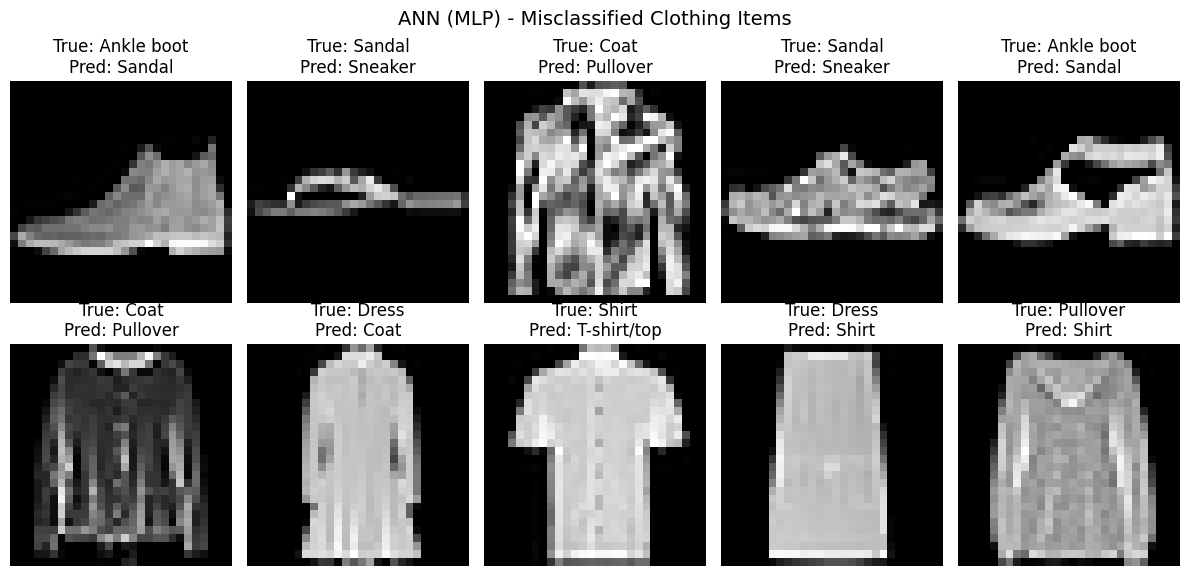

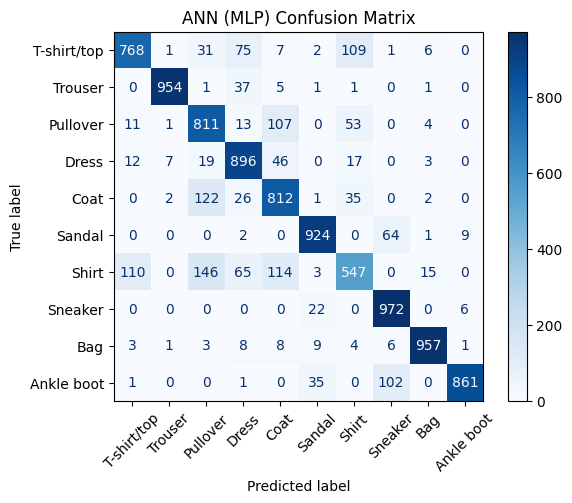

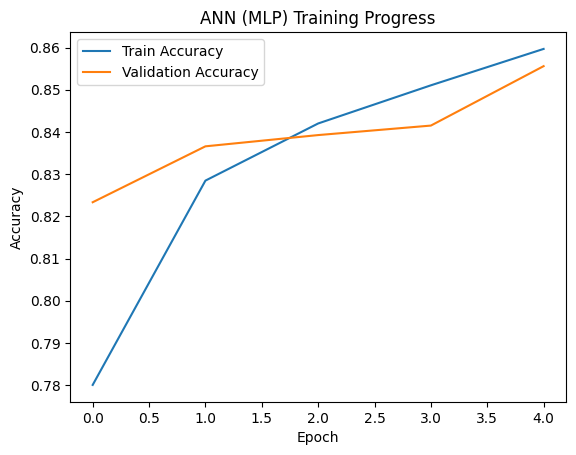

 ANN (MLP) Model saved as 'ANN_(MLP)_model.pth'


 Training CNN (with Padding) Model...
Epoch 1/5 - Train Acc: 0.7667, Val Acc: 0.8434
Epoch 2/5 - Train Acc: 0.8360, Val Acc: 0.8611
Epoch 3/5 - Train Acc: 0.8541, Val Acc: 0.8720
Epoch 4/5 - Train Acc: 0.8665, Val Acc: 0.8796
Epoch 5/5 - Train Acc: 0.8734, Val Acc: 0.8814

 Evaluating CNN (with Padding) Model on Test Data...
CNN (with Padding) - Test Loss: 0.3105, Test Accuracy: 88.47%

Showing some misclassified clothing items for CNN (with Padding)...



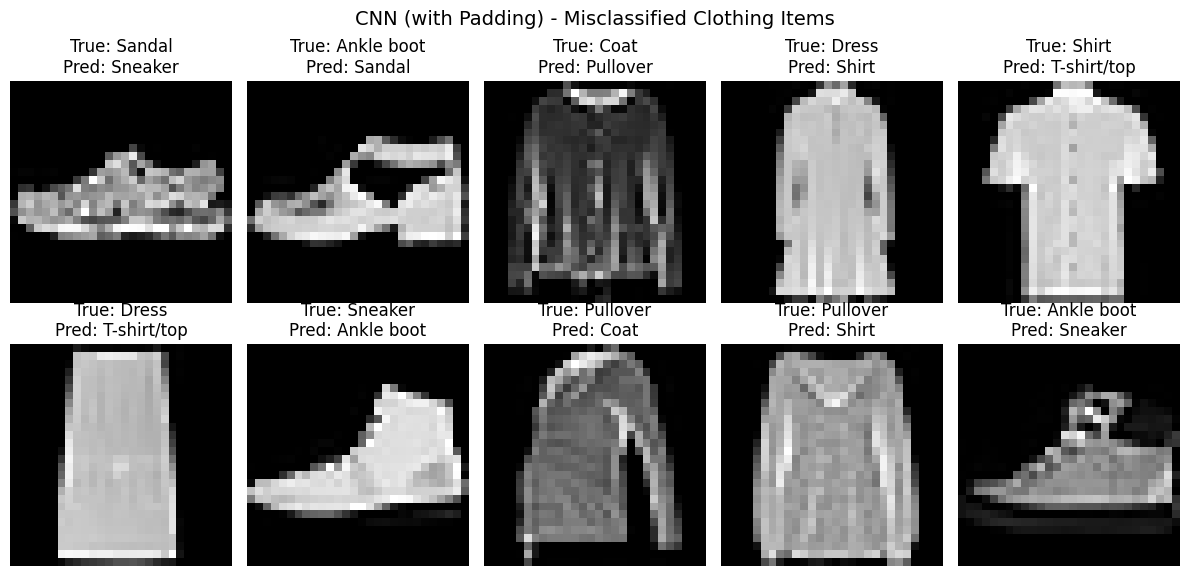

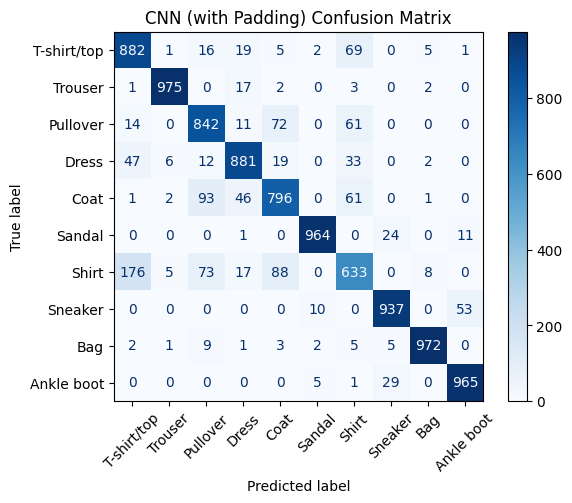

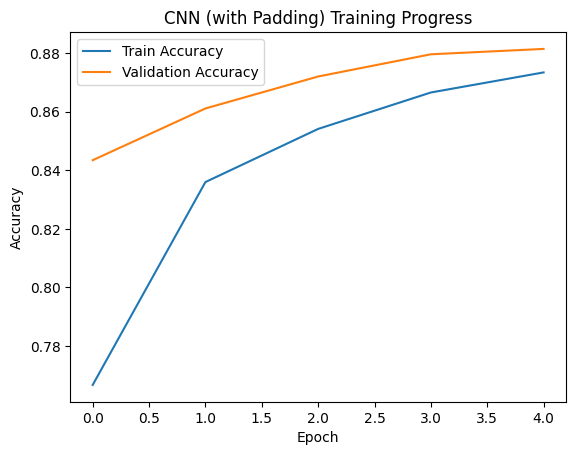

 CNN (with Padding) Model saved as 'CNN_(with_Padding)_model.pth'



In [28]:
def run_experiment(model_class, name):
    print(f"\n Training {name} Model...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 5
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


    # -----------------------------
    #  Final Test Evaluation
    # -----------------------------
    print(f"\n Evaluating {name} Model on Test Data...")
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
    print(f"{name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

    # -----------------------------
    #  Comparison of Clothes (Misclassifications)
    # -----------------------------
    classes = train_data_full.classes
    incorrect_indices = np.where(preds != labels)[0]

    if len(incorrect_indices) > 0:
        print(f"\nShowing some misclassified clothing items for {name}...\n")
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        axes = axes.flatten()
        for i, ax in enumerate(axes):
            if i >= len(incorrect_indices):
                break
            idx = incorrect_indices[i]
            image, true_label = test_data[idx]
            predicted_label = preds[idx]
            ax.imshow(image.squeeze(), cmap='gray')
            ax.set_title(f"True: {classes[true_label]}\nPred: {classes[predicted_label]}")
            ax.axis('off')
        plt.suptitle(f"{name} - Misclassified Clothing Items", fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No misclassifications found for {name} (perfect accuracy on test set).")

    # -----------------------------
    #  Confusion Matrix
    # -----------------------------
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Accuracy Curves
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{name} Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Save model
    torch.save(model.state_dict(), f"{name.replace(' ', '_')}_model.pth")
    print(f" {name} Model saved as '{name.replace(' ', '_')}_model.pth'\n")

# -----------------------------
# 5. Run Both Models (ANN & CNN)
# -----------------------------
run_experiment(ANN, "ANN (MLP)")
run_experiment(CNN, "CNN (with Padding)")

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [15]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_data_full))
val_size = len(train_data_full) - train_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [16]:
class EnhancedANN(nn.Module):
    """Enhanced ANN with BatchNorm + Dropout"""
    def __init__(self):
        super(EnhancedANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = self.fc3(x)
        return x

In [17]:
class EnhancedCNN(nn.Module):
    """Enhanced CNN with BatchNorm + Dropout"""
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    correct, total_loss = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


def evaluate(model, loader, criterion, device):
    model.eval()
    correct, total_loss = 0, 0
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            preds.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())
    return total_loss / len(loader), correct / len(loader.dataset), np.array(preds), np.array(labels)


In [25]:
def run_experiment(model_class, name, epochs=5):
    print(f"\n Training {name} ...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs = [], []
    for epoch in range(epochs):
        tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train: {tr_acc:.4f}, Val: {val_acc:.4f}")

    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
    print(f"\n {name} Test Accuracy: {test_acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=train_data_full.classes)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Accuracy Curves
    plt.plot(train_accs, label="Train")
    plt.plot(val_accs, label="Validation")
    plt.title(f"{name} Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return test_acc



🚀 Training ANN (Base) ...
Epoch 1/5 - Train: 0.7779, Val: 0.8327
Epoch 2/5 - Train: 0.8308, Val: 0.8312
Epoch 3/5 - Train: 0.8441, Val: 0.8522
Epoch 4/5 - Train: 0.8531, Val: 0.8537
Epoch 5/5 - Train: 0.8594, Val: 0.8507

📊 ANN (Base) Test Accuracy: 85.28%


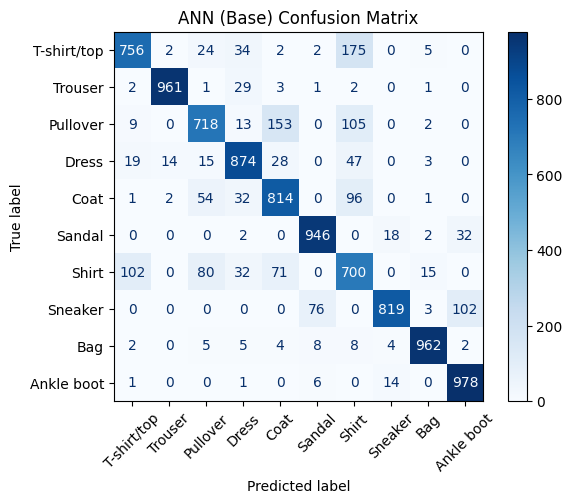

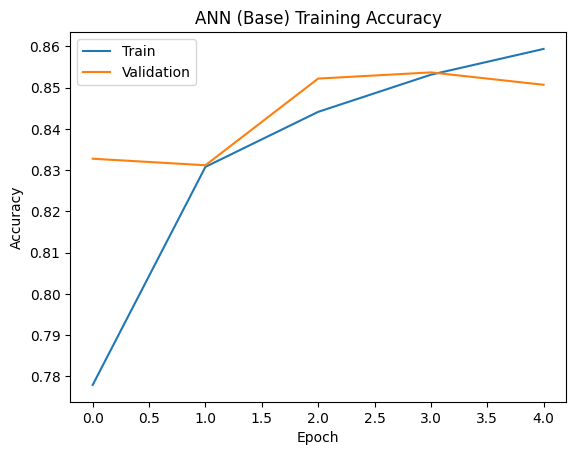


🚀 Training CNN (Base) ...
Epoch 1/5 - Train: 0.7651, Val: 0.8416
Epoch 2/5 - Train: 0.8387, Val: 0.8569
Epoch 3/5 - Train: 0.8555, Val: 0.8681
Epoch 4/5 - Train: 0.8647, Val: 0.8773
Epoch 5/5 - Train: 0.8722, Val: 0.8810

📊 CNN (Base) Test Accuracy: 88.18%


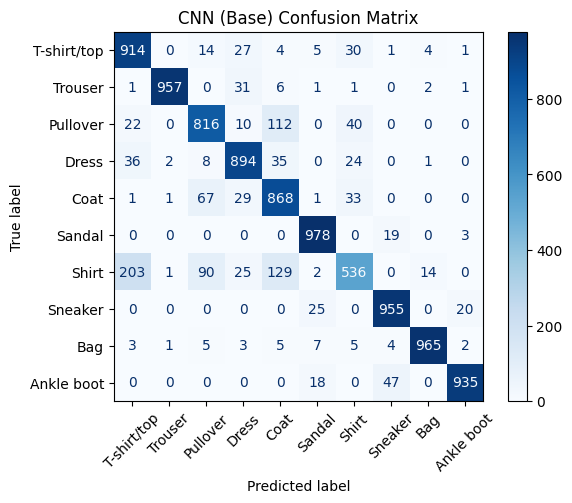

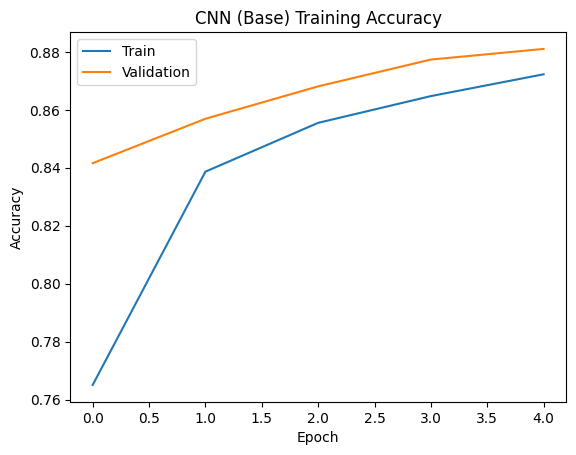


🚀 Training Enhanced ANN ...
Epoch 1/5 - Train: 0.7748, Val: 0.8374
Epoch 2/5 - Train: 0.8155, Val: 0.8439
Epoch 3/5 - Train: 0.8301, Val: 0.8518
Epoch 4/5 - Train: 0.8381, Val: 0.8583
Epoch 5/5 - Train: 0.8416, Val: 0.8655

📊 Enhanced ANN Test Accuracy: 86.26%


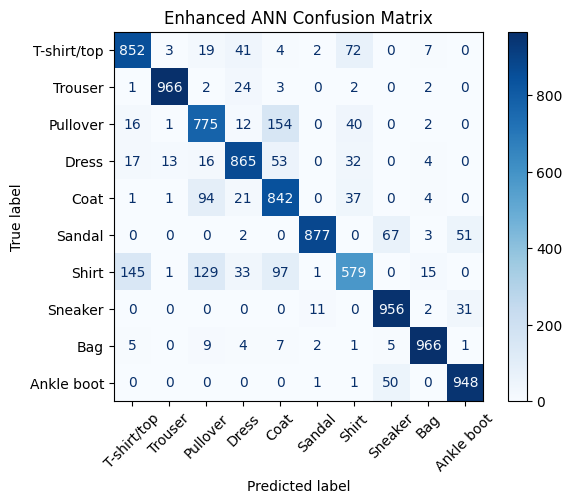

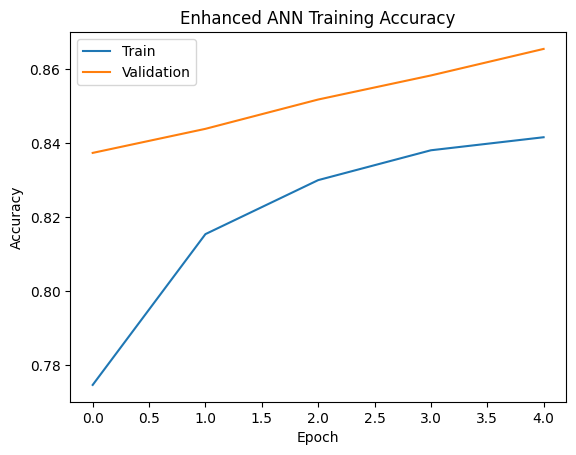


🚀 Training Enhanced CNN ...
Epoch 1/5 - Train: 0.8203, Val: 0.8726
Epoch 2/5 - Train: 0.8680, Val: 0.8833
Epoch 3/5 - Train: 0.8804, Val: 0.8912
Epoch 4/5 - Train: 0.8889, Val: 0.9016
Epoch 5/5 - Train: 0.8969, Val: 0.9027

📊 Enhanced CNN Test Accuracy: 90.44%


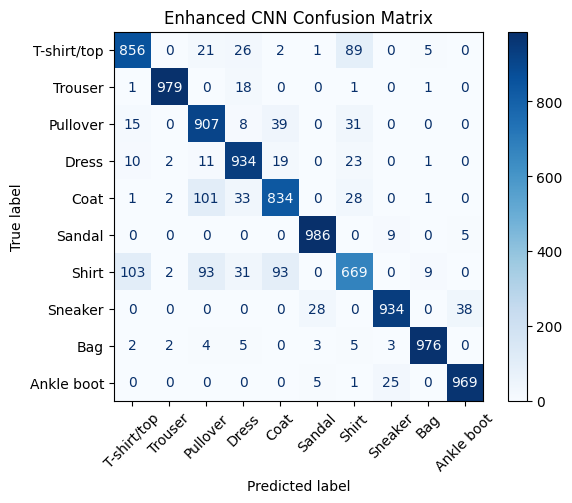

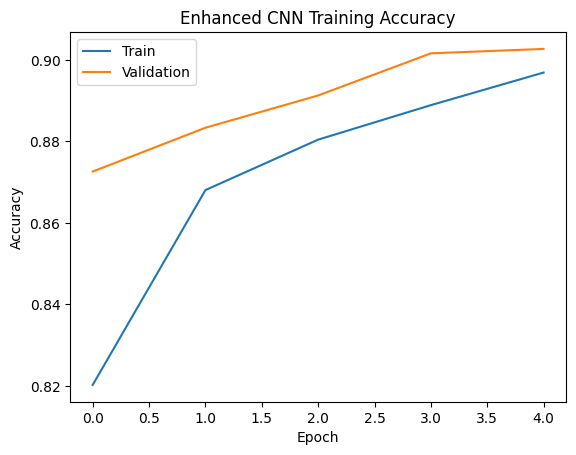

In [20]:
ann_acc = run_experiment(ANN, "ANN (Base)")
cnn_acc = run_experiment(CNN, "CNN (Base)")
enh_ann_acc = run_experiment(EnhancedANN, "Enhanced ANN")
enh_cnn_acc = run_experiment(EnhancedCNN, "Enhanced CNN")


===  Model Comparison Summary ===
          Model  Test Accuracy  Improvement over Base
0           ANN         0.8528                   0.00
1           CNN         0.8818                   0.00
2  Enhanced ANN         0.8626                   0.98
3  Enhanced CNN         0.9044                   2.26


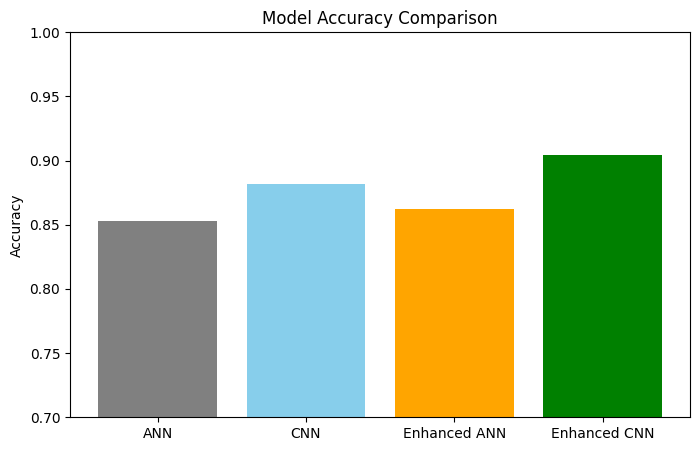

In [26]:
summary = pd.DataFrame({
    "Model": ["ANN", "CNN", "Enhanced ANN", "Enhanced CNN"],
    "Test Accuracy": [ann_acc, cnn_acc, enh_ann_acc, enh_cnn_acc]
})

summary["Improvement over Base"] = [
    0,
    0,
    (enh_ann_acc - ann_acc) * 100,
    (enh_cnn_acc - cnn_acc) * 100
]

print("\n===  Model Comparison Summary ===")
print(summary)

plt.figure(figsize=(8, 5))
plt.bar(summary["Model"], summary["Test Accuracy"], color=["gray", "skyblue", "orange", "green"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.show()

In [21]:
print("\n===  Reflection & Insights ===")
print("• CNNs outperform ANNs because they capture spatial features in images.")
print("• Enhanced models (with BatchNorm + Dropout) achieved higher generalization and stability.")
print("• Data augmentation (rotation, flip) improved CNN robustness against overfitting.")
print("• Adam optimizer accelerated convergence with adaptive learning rates.")
print("• Confusions mostly occur between visually similar classes (e.g., Shirt vs. Coat).")


===  Reflection & Insights ===
• CNNs outperform ANNs because they capture spatial features in images.
• Enhanced models (with BatchNorm + Dropout) achieved higher generalization and stability.
• Data augmentation (rotation, flip) improved CNN robustness against overfitting.
• Adam optimizer accelerated convergence with adaptive learning rates.
• Confusions mostly occur between visually similar classes (e.g., Shirt vs. Coat).
